# Q1 MLP and CNN
## Q 1.1 MLP original definition, experiment, and Write up
### Q.1.1.1 MLP definition

In [67]:
from torch import sigmoid
from torch.nn import Module, Linear
import torch.nn


class MLP(Module): 
    def __init__(self, input_size, *hidden_nodes):
        super(MLP, self).__init__();
        # print(hidden_nodes);
        last  = input_size
        self.LEN = len(hidden_nodes)
        for i, node in enumerate(hidden_nodes):
            setattr(self, 'fc' + str(i), Linear(last, node))
            last = node
        setattr(self, 'fc'+str(self.LEN),  Linear(last, 10))
        self.input_size = input_size


    def forward(self, x):
        x = x.view(-1, self.input_size)
        for index in range(self.LEN):
            x = sigmoid(getattr(self, 'fc'+str(index))(x))
        x = getattr(self, 'fc'+ str(self.LEN))(x)
        return x




# sample MLP model: 
model = MLP(10, 512, 512)
print(model)
print([x for x in model.parameters()])
print( getattr(model, 'fc'+str(0)))



(512, 512)
MLP(
  (fc0): Linear(in_features=10, out_features=512, bias=True)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
[Parameter containing:
tensor([[ 0.1637, -0.2748,  0.0675,  ...,  0.2007,  0.0803, -0.2920],
        [-0.0083, -0.0683,  0.1496,  ...,  0.1516, -0.0780, -0.3161],
        [-0.1295, -0.1306,  0.2398,  ...,  0.2544,  0.0582, -0.2623],
        ...,
        [ 0.0734,  0.0004,  0.1142,  ...,  0.2497,  0.0885,  0.0410],
        [ 0.0974, -0.1083, -0.0481,  ...,  0.2190, -0.0223, -0.0644],
        [ 0.2079,  0.0652,  0.2440,  ..., -0.0982, -0.0100,  0.1832]],
       requires_grad=True), Parameter containing:
tensor([ 0.0227, -0.0517,  0.1574, -0.0738,  0.1922, -0.2709,  0.1740,  0.1325,
         0.1628, -0.1105, -0.1891,  0.2198,  0.1540, -0.1412,  0.1886,  0.3066,
        -0.2482, -0.0903,  0.3101,  0.1095,  0.2331,  0.1364, -0.0913, -0.1956,
         0.0352,  0.0635,  0.3072, -0.1334, -0.0814

### 1.1.2 Training Algorithm Definition

In [86]:
from torch import device, no_grad
from time import time

def train(model, optimizer, criterion, train_loader, val_loader=None, epochs=5):
    device = "cpu"
    model = model.to(device)
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    for epoch in range(1, epochs+1):
        start = time()
        model.train()
        train_loss = 0
        correct = 0
        count = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss)
        accuracy = correct / len(train_loader.dataset)
        train_accuracies.append(accuracy)
        print('Train Epoch: %i, Loss: %f, Accuracy: %f' % (epoch, train_loss, accuracy))
        print('Training time for this epoch %f' % (time() - start))
        if val_loader is not None:
            model.eval()
            val_loss = 0
            correct = 0
            with no_grad():
                for batch_idx, (data, target) in enumerate(val_loader):
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    pred = output.max(1, keepdim=True)[1]
                    correct += pred.eq(target.view_as(pred)).sum().item()
                    loss = criterion(output, target)
                    val_loss += loss.item()
            val_losses.append(val_loss)
            accuracy = correct / len(val_loader.dataset)
            val_accuracies.append(accuracy)
            print('Val Epoch:   %i, Loss: %f, Accuracy: %f' % (epoch, val_loss, accuracy))
        else: 
            print ('Oh no no validation')
    return train_losses, train_accuracies, val_losses, val_accuracies


def predict(model, criterion, test_loader):
    device = "cpu"
    model.eval()
    test_loss = 0
    correct = 0
    with no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = criterion(output, target)
            test_loss += loss.item()
    accuracy = correct / len(test_loader.dataset)
    print('Test Loss: %f, Test Accuracy: %f' % (test_loss, accuracy))

### 1.1.3 Prepare Data

In [88]:
import numpy as np


from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

train_set = datasets.CIFAR10(root='./data/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
test_set_ = datasets.CIFAR10(root='./data/', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

n_train = len(train_set)
batch_size = 32
split = n_train // 5
indices = np.random.permutation(n_train)
subset_sampler = SubsetRandomSampler(indices[:split])
train_loader = DataLoader(train_set, batch_size=batch_size, sampler=subset_sampler)
n_test = len(test_set_)
val_set, test_set = random_split(test_set_, [n_test//2, n_test//2])
print(val_set, test_set)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
<torch.utils.data.dataset.Subset object at 0x0000026C1DD8DF10> <torch.utils.data.dataset.Subset object at 0x0000026C1DD8D760>


### 1.1.4 MLP initialization

In [87]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss


input_size = train_set.data[0].reshape((-1, 1)).shape[0]
model = MLP(input_size, 512)
print(model)

learning_rate = 1e-4
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = CrossEntropyLoss()
train_losses_512, train_accuracies_512, val_losses_512, val_accuracies_512 = train(model, optimizer, criterion, train_loader, val_loader, 5)


(512,)
Train Epoch: 1, Loss: 611.445625, Accuracy: 0.063400
Training time for this epoch 16.747026
Val Epoch:   1, Loss: 292.325163, Accuracy: 0.358400
Train Epoch: 2, Loss: 564.245845, Accuracy: 0.075080
Training time for this epoch 21.786152
Val Epoch:   2, Loss: 282.735326, Accuracy: 0.383400
Train Epoch: 3, Loss: 547.485880, Accuracy: 0.079160
Training time for this epoch 16.847360
Val Epoch:   3, Loss: 278.395043, Accuracy: 0.386200
Train Epoch: 4, Loss: 535.021770, Accuracy: 0.082200
Training time for this epoch 16.803315
Val Epoch:   4, Loss: 275.778561, Accuracy: 0.394400
Train Epoch: 5, Loss: 526.392052, Accuracy: 0.084380
Training time for this epoch 18.094434
Val Epoch:   5, Loss: 273.082122, Accuracy: 0.399000


### 1.1.5 Tunning Parameter: adding layers

In [109]:
model_layer_x2 = MLP(input_size, 512, 512)
print(model_layer_x2)
learning_rate = 1e-4
optimizer_x2 = torch.optim.Adam(model_layer_x2.parameters(), lr=learning_rate)
train_losses_512_x2, train_accuracies_512_x2, val_losses_512_x2, val_accuracies_512_x2 = train(model_layer_x2, optimizer_x2, criterion, train_loader, val_loader, 5)


(512, 512)
MLP(
  (fc0): Linear(in_features=3072, out_features=512, bias=True)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Train Epoch: 1, Loss: 654.788213, Accuracy: 0.051340
Training time for this epoch 18.478823
Val Epoch:   1, Loss: 305.994561, Accuracy: 0.311600
Train Epoch: 2, Loss: 592.432493, Accuracy: 0.065340
Training time for this epoch 22.390799
Val Epoch:   2, Loss: 291.688990, Accuracy: 0.342200
Train Epoch: 3, Loss: 567.854114, Accuracy: 0.071280
Training time for this epoch 21.392097
Val Epoch:   3, Loss: 284.102225, Accuracy: 0.357400
Train Epoch: 4, Loss: 549.656227, Accuracy: 0.075260
Training time for this epoch 18.753564
Val Epoch:   4, Loss: 277.854345, Accuracy: 0.376000
Train Epoch: 5, Loss: 536.493504, Accuracy: 0.078680
Training time for this epoch 20.508371
Val Epoch:   5, Loss: 274.388142, Accuracy: 0.374000


In [110]:
model_layer_x3 = MLP(input_size, 512, 512, 512)
print(model_layer_x3)
learning_rate = 1e-4
optimizer_x3 = torch.optim.Adam(model_layer_x3.parameters(), lr=learning_rate)
train_losses_512_x3, train_accuracies_512_x3, val_losses_512_x3, val_accuracies_512_x3 = train(model_layer_x3, optimizer_x3, criterion, train_loader, val_loader, 5)


(512, 512, 512)
MLP(
  (fc0): Linear(in_features=3072, out_features=512, bias=True)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)
Train Epoch: 1, Loss: 681.610437, Accuracy: 0.034060
Training time for this epoch 22.208609
Val Epoch:   1, Loss: 321.271056, Accuracy: 0.216200
Train Epoch: 2, Loss: 619.796469, Accuracy: 0.052060
Training time for this epoch 20.045270
Val Epoch:   2, Loss: 304.773967, Accuracy: 0.277800
Train Epoch: 3, Loss: 594.707646, Accuracy: 0.060140
Training time for this epoch 23.982804
Val Epoch:   3, Loss: 297.138387, Accuracy: 0.312600
Train Epoch: 4, Loss: 578.203065, Accuracy: 0.067240
Training time for this epoch 28.367988
Val Epoch:   4, Loss: 290.572063, Accuracy: 0.334800
Train Epoch: 5, Loss: 564.336313, Accuracy: 0.069060
Training time for this epoch 23.381881
Val Epoch:   5, Loss: 286.862280, Accuracy: 0.339800


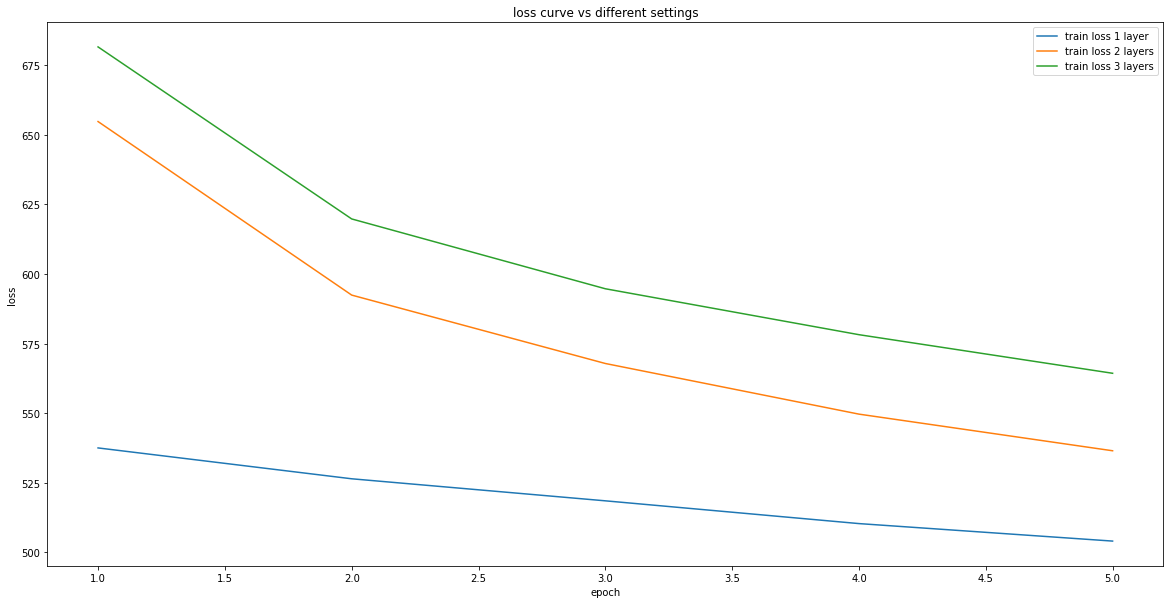

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.title('loss curve vs different Layers')
plt.plot([i+1 for i in range(5)], train_losses_512)
plt.plot([i+1 for i in range(5)], train_losses_512_x2)
plt.plot([i+1 for i in range(5)], train_losses_512_x3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss 1 layer', 'train loss 2 layers', 'train loss 3 layers'])
plt.show()

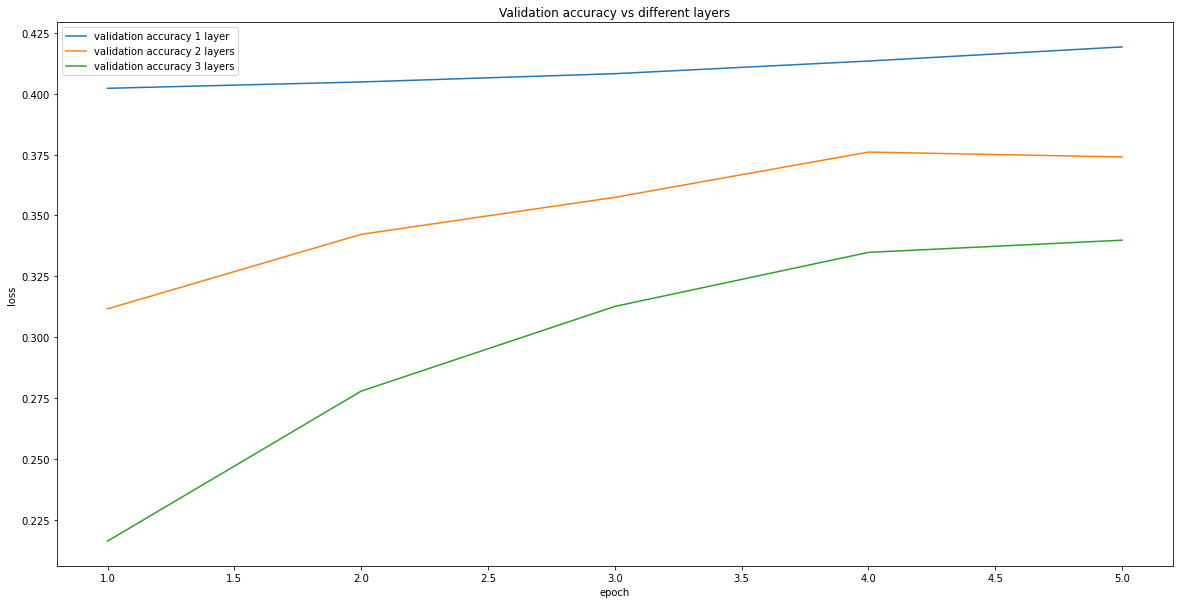

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.title('Validation accuracy vs different layers')
plt.plot([i+1 for i in range(5)], val_accuracies_512)
plt.plot([i+1 for i in range(5)], val_accuracies_512_x2)
plt.plot([i+1 for i in range(5)], val_accuracies_512_x3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['validation accuracy 1 layer', 'validation accuracy 2 layers', 'validation accuracy 3 layers'])
plt.show()

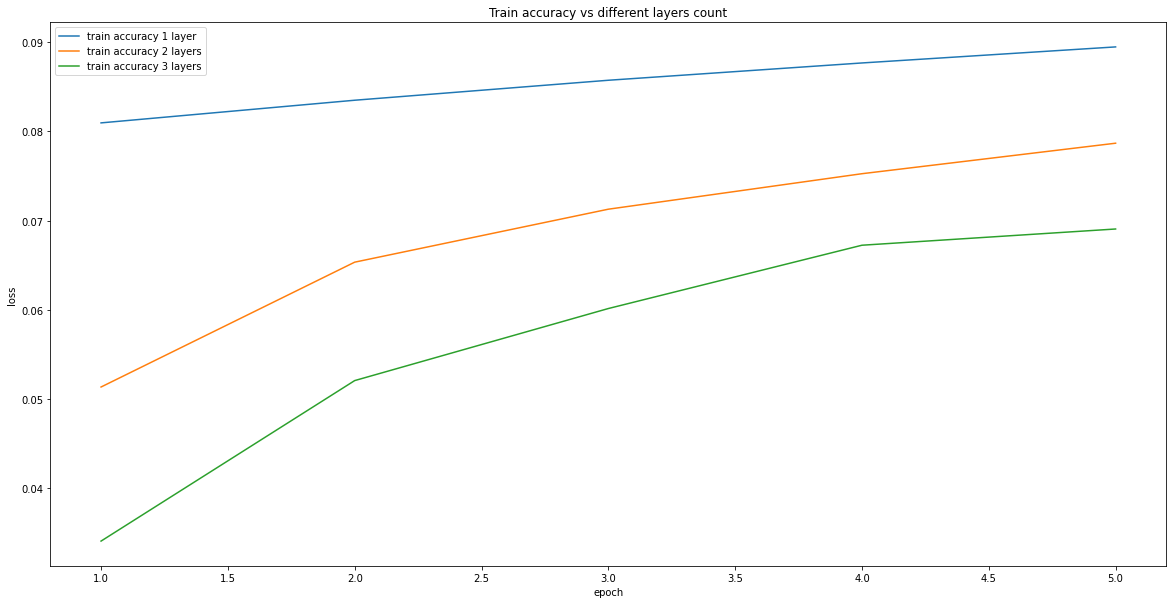

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.title('Train accuracy vs different layers count')
plt.plot([i+1 for i in range(5)], train_accuracies_512)
plt.plot([i+1 for i in range(5)], train_accuracies_512_x2)
plt.plot([i+1 for i in range(5)], train_accuracies_512_x3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train accuracy 1 layer', 'train accuracy 2 layers', 'train accuracy 3 layers'])
plt.show()

In [130]:
predict_layer_x1 = predict(model, criterion, test_loader)
predict_layer_x2 = predict(model_layer_x2, criterion, test_loader)
predict_layer_x3 = predict(model_layer_x3, criterion, test_loader)

predict_layer_x2 = predict(model_1024, criterion, test_loader)
predict_layer_x3 = predict(model_1024_1024, criterion, test_loader)


Test Loss: 265.513698, Test Accuracy: 0.418000
Test Loss: 275.048286, Test Accuracy: 0.376000
Test Loss: 289.225743, Test Accuracy: 0.328000
Test Loss: 271.855212, Test Accuracy: 0.390000
Test Loss: 270.513086, Test Accuracy: 0.399600


# 1.1.6 Try Different dimension layers

In [106]:
model_1024 = MLP(input_size, 1024, 512)
print(model_1024)
learning_rate = 1e-4
optimizer_1024 = torch.optim.Adam(model_1024.parameters(), lr=learning_rate)
train_losses_1024, train_accuracies_1024, val_losses_1024, val_accuracies_1024 = train(model_1024, optimizer_1024, criterion, train_loader, val_loader, 5)

model_1024_1024 = MLP(input_size, 1024, 1024)
print(model_1024_1024)
learning_rate = 1e-4
optimizer_1024_1024 = torch.optim.Adam(model_1024_1024.parameters(), lr=learning_rate)
train_losses_1024_1024, train_accuracies_1024_1024, val_losses_1024_1024, val_accuracies_1024_1024 = train(model_1024_1024, optimizer_1024_1024, criterion, train_loader, val_loader, 5)


(1024, 512)
MLP(
  (fc0): Linear(in_features=3072, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Train Epoch: 1, Loss: 642.802906, Accuracy: 0.051960
Training time for this epoch 31.558397
Val Epoch:   1, Loss: 301.323003, Accuracy: 0.293600
Train Epoch: 2, Loss: 581.056830, Accuracy: 0.068340
Training time for this epoch 34.667790
Val Epoch:   2, Loss: 288.526539, Accuracy: 0.334000
Train Epoch: 3, Loss: 556.795776, Accuracy: 0.075260
Training time for this epoch 29.967841
Val Epoch:   3, Loss: 279.416899, Accuracy: 0.367200
Train Epoch: 4, Loss: 539.071075, Accuracy: 0.078440
Training time for this epoch 27.819813
Val Epoch:   4, Loss: 274.276935, Accuracy: 0.379800
Train Epoch: 5, Loss: 526.213095, Accuracy: 0.081500
Training time for this epoch 36.660045
Val Epoch:   5, Loss: 271.257268, Accuracy: 0.394400
(1024, 1024)
MLP(
  (fc0): Linear(in_features=3072, out_features=102

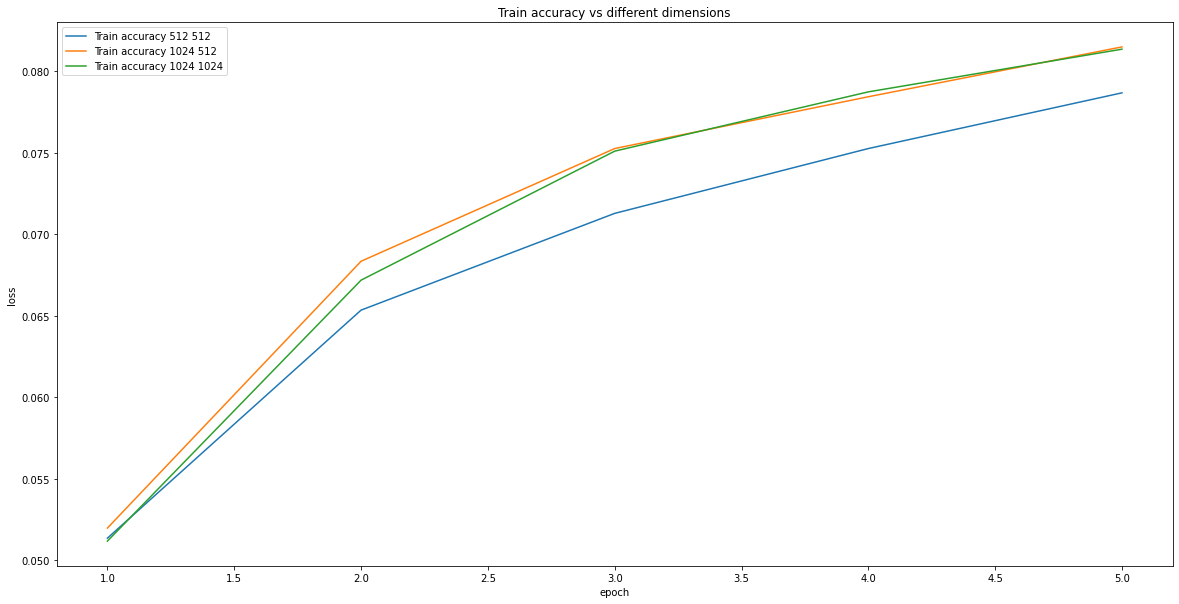

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.title('Train accuracy vs different dimensions')
plt.plot([i+1 for i in range(5)], train_accuracies_512_x2)
plt.plot([i+1 for i in range(5)], train_accuracies_1024)
plt.plot([i+1 for i in range(5)], train_accuracies_1024_1024)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train accuracy 512 512', 'Train accuracy 1024 512', 'Train accuracy 1024 1024'])
plt.show()

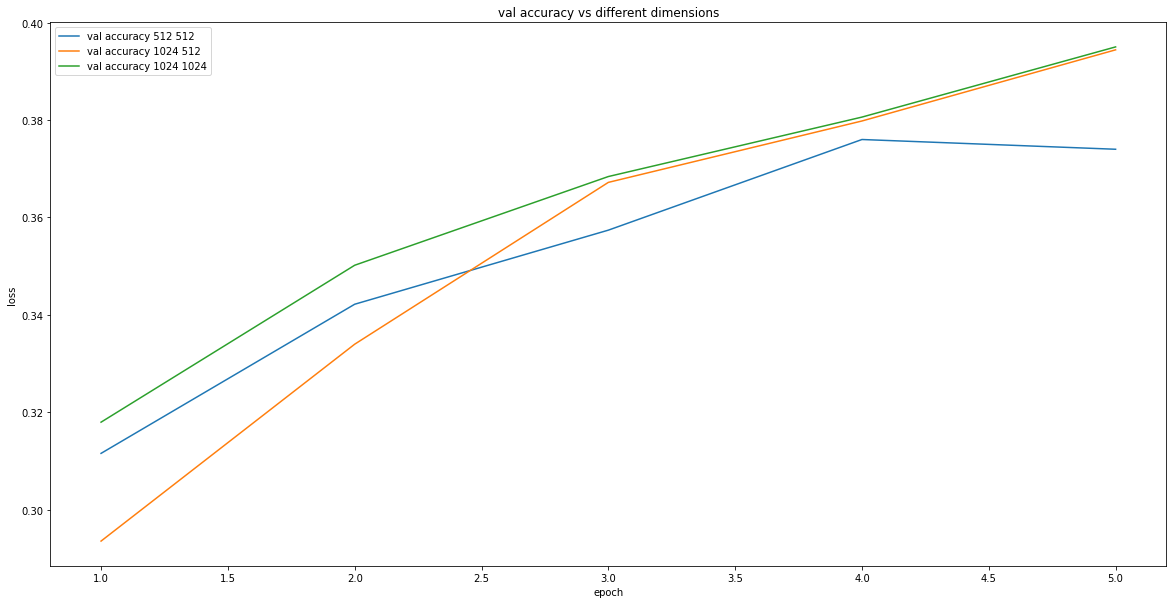

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.title('val accuracy vs different dimensions')
plt.plot([i+1 for i in range(5)], val_accuracies_512_x2)
plt.plot([i+1 for i in range(5)], val_accuracies_1024)
plt.plot([i+1 for i in range(5)], val_accuracies_1024_1024)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['val accuracy 512 512', 'val accuracy 1024 512', 'val accuracy 1024 1024'])
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.title('loss curve vs different settings')
plt.plot([i+1 for i in range(5)], val_losses_512_x2)
plt.plot([i+1 for i in range(5)], val_accuracies_1024)
plt.plot([i+1 for i in range(5)], val_accuracies_1024_1024)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Loss 512 512', 'Loss 1024 512', 'Loss 1024 1024'])
plt.show()

In [131]:
predict_layer_x2 = predict(model_1024, criterion, test_loader)
predict_layer_x3 = predict(model_1024_1024, criterion, test_loader)

Test Loss: 272.283916, Test Accuracy: 0.390000
Test Loss: 270.538239, Test Accuracy: 0.399600


## 1.2 CNN1: Build a Convolutional Neural Network with the Following Architecture

### 1.2.1 CNN1 model definition

In [135]:
from torch.nn import Conv2d, Linear, functional as F

class CNN1(Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = Conv2d(3, 64, 3, 1, 1)
        self.conv2 = Conv2d(64, 64, 3, 1, 1)
        self.fc1 = Linear(64*32*32, 512)
        self.fc2 = Linear(512, 512)
        self.fc3 = Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 64*32*32)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x


### 1.2.2 CNN2 Configuration


In [136]:
class CNN2(Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = Conv2d(3, 64, 3, 1, 1)
        self.conv2 = Conv2d(64, 64, 3, 1, 1)
        self.fc1 = Linear(64 * 8 * 8, 512)
        self.fc2 = Linear(512, 512)
        self.fc3 = Linear(512, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, 64*8*8)
        x = torch.sigmoid(self.fc1(x))
        x = F.dropout(x, 0.2)
        x = torch.sigmoid(self.fc2(x))
        x = F.dropout(x, 0.2)
        x = self.fc3(x)
        return x

### 1.2.3 Training

In [138]:
model = CNN1()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = CrossEntropyLoss()
train_losses_cnn1, train_accuracies_cnn1,  val_losses_cnn1, val_accuracies_cnn1 = train(model, optimizer, criterion, train_loader, val_loader)


Train Epoch: 1, Loss: 619.561079, Accuracy: 0.059240
Training time for this epoch 297.385428
Val Epoch:   1, Loss: 276.108786, Accuracy: 0.389600
Train Epoch: 2, Loss: 512.894924, Accuracy: 0.085200
Training time for this epoch 282.730664
Val Epoch:   2, Loss: 250.823389, Accuracy: 0.435800
Train Epoch: 3, Loss: 455.375140, Accuracy: 0.097520
Training time for this epoch 261.979996
Val Epoch:   3, Loss: 229.651473, Accuracy: 0.473200
Train Epoch: 4, Loss: 415.116985, Accuracy: 0.106180
Training time for this epoch 239.765321
Val Epoch:   4, Loss: 220.313597, Accuracy: 0.499400
Train Epoch: 5, Loss: 379.269352, Accuracy: 0.114920
Training time for this epoch 235.002580
Val Epoch:   5, Loss: 213.916207, Accuracy: 0.508200


In [140]:
predict(model, criterion, test_loader)

Test Loss: 369.287524, Test Accuracy: 0.095000


## 1.2.4 Training CNN2 

In [143]:
model = CNN2()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses_cnn2, train_accuracies_cnn2,  val_losses_cnn2, val_accuracies_cnn2 = train(model, optimizer, criterion, train_loader, val_loader)


Train Epoch: 1, Loss: 666.578836, Accuracy: 0.043140
Training time for this epoch 76.839818
Val Epoch:   1, Loss: 305.815767, Accuracy: 0.305600
Train Epoch: 2, Loss: 587.062485, Accuracy: 0.065280
Training time for this epoch 58.979867
Val Epoch:   2, Loss: 282.379301, Accuracy: 0.358000
Train Epoch: 3, Loss: 541.708752, Accuracy: 0.076220
Training time for this epoch 48.302180
Val Epoch:   3, Loss: 262.097819, Accuracy: 0.398200
Train Epoch: 4, Loss: 504.649510, Accuracy: 0.082820
Training time for this epoch 47.178579
Val Epoch:   4, Loss: 247.416687, Accuracy: 0.438200
Train Epoch: 5, Loss: 476.953135, Accuracy: 0.089040
Training time for this epoch 56.964322
Val Epoch:   5, Loss: 240.372498, Accuracy: 0.443200


In [144]:
predict(model, criterion, test_loader)

Test Loss: 236.443035, Test Accuracy: 0.457000


predict(model, criterion, test_loader)

### 1.2.5 Plotting

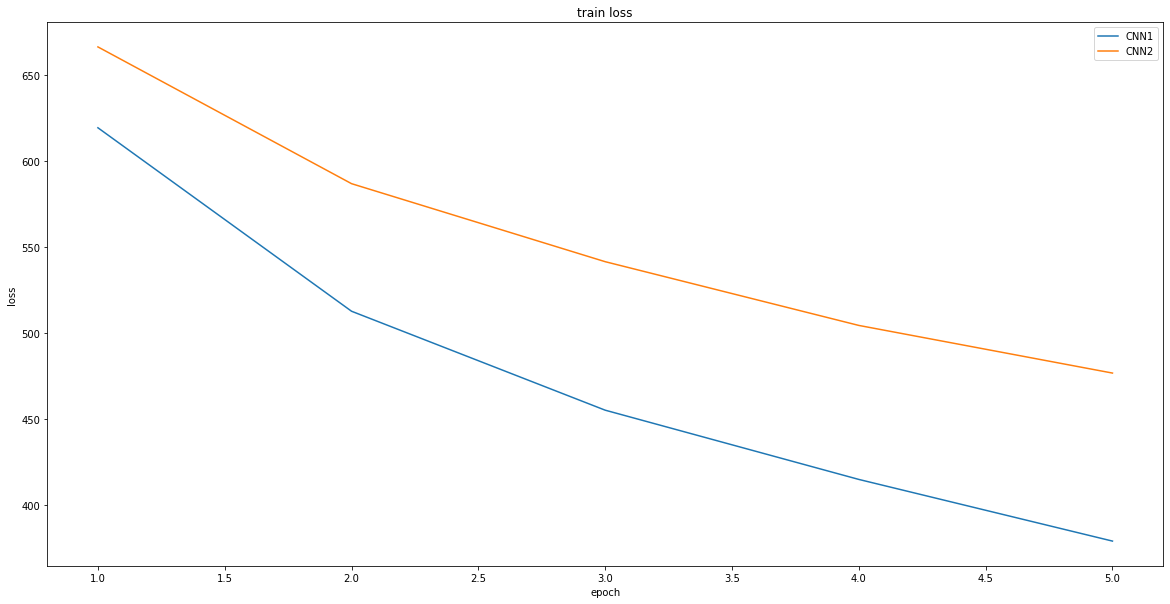

In [145]:
plt.figure(figsize=(20,10))
plt.title('train loss')
plt.plot([i+1 for i in range(5)], train_losses_cnn1)
plt.plot([i+1 for i in range(5)], train_losses_cnn2)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['CNN1', 'CNN2'])
plt.show()

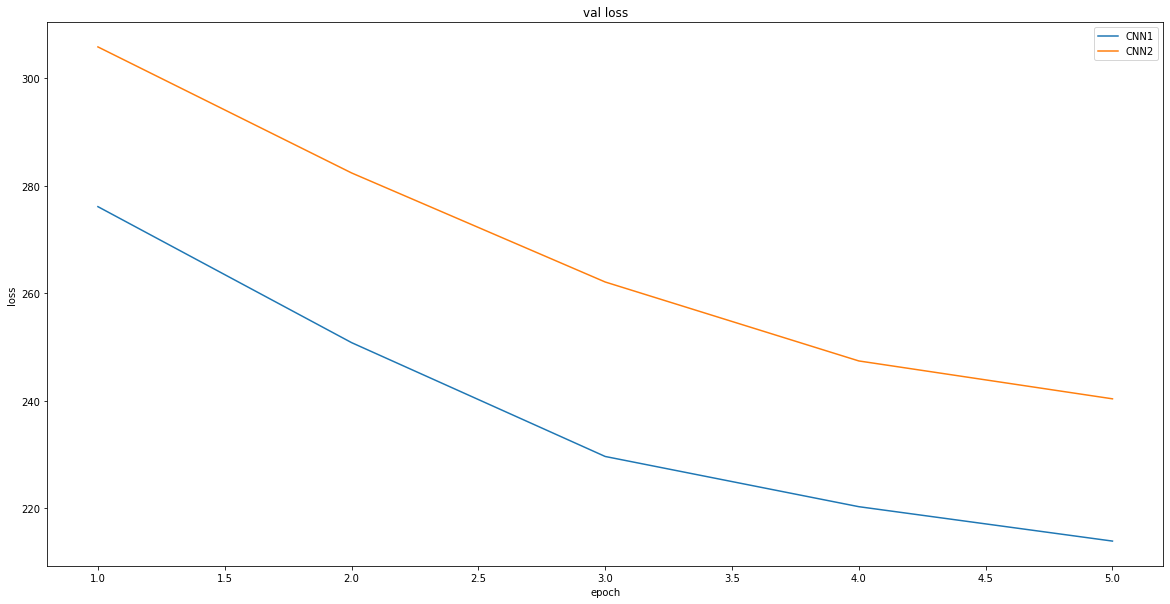

In [146]:
plt.figure(figsize=(20,10))
plt.title('val loss')
plt.plot([i+1 for i in range(5)], val_losses_cnn1)
plt.plot([i+1 for i in range(5)], val_losses_cnn2)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['CNN1', 'CNN2'])
plt.show()

### 1.3.1 Reference
- ECE 657 Learn Page
- https://keras.io/api/layers/convolution_layers/
- https://github.com/paulwong16/ECE657-Tools_of_Intelligent_Sys_Design/blob/master/a3/ece657_a3.pdf
- https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5